In [1]:
import circle
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time
from scipy import stats, signal, ndimage, optimize, interpolate, optimize
import matplotlib
from tqdm import tqdm
import pandas as pd
from pylab import mpl
import traceback
from joblib import Parallel, delayed
import sys

In [2]:
path=r"D:\2023_11_04_YNB\06_35000x_alpha0p42\scan_x128_y128.raw"
#path=r"C:\Users\admin\Desktop\20201018\field cool_80kX_inner_3\scan_x220_y220.raw"
# Read data
data = circle.readData(path)
imgh, imgw, pxh, pxw = data.shape

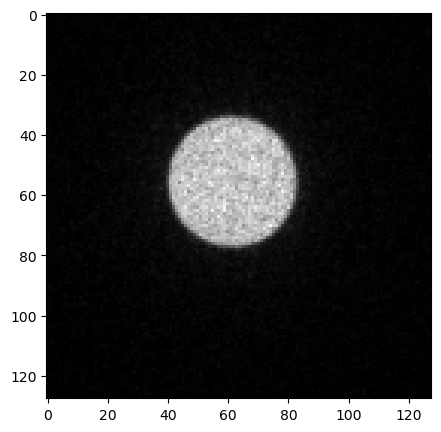

In [3]:
# Select one of the diffraction disks
# Process the data array by replacing NaN values with 0, shifting the data values to non-negative,and adding a small positive offset.
data_one_pat = circle.handData(data[1][1])


# Normalize the data array and convert it to a grayscale pixel value range
show_one_pat = (((data_one_pat - data_one_pat.min()) / (data_one_pat.max() - data_one_pat.min())) * 255).astype(np.uint8)
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(show_one_pat, cmap='gray')
plt.show()

ref_x= 62.82871096479253 ref_y= 53.95135891002734 ref_r= 21.683431428778015


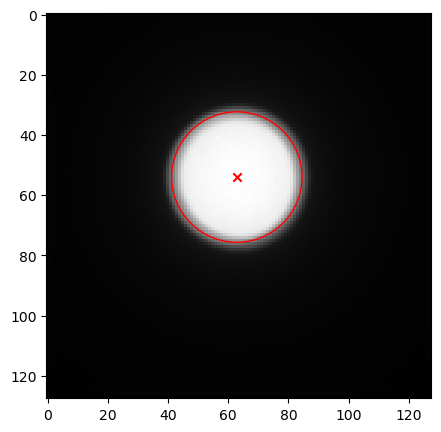

In [4]:
# Diffraction disk superposition
ref = np.nansum(data, axis=(0, 1)) / (imgh * imgw)
# Fitting circle
binary = circle.filtering(ref)
ref_y, ref_x, ref_r = circle.find_circle_in_image(binary)  # Fit a circle to the reference pattern
print('ref_x=', ref_x, 'ref_y=', ref_y, 'ref_r=', ref_r)
# Create a graphics window
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(ref, cmap='gray')
c = plt.Circle((ref_x, ref_y),ref_r, color='red', linewidth=1, fill=False)
plt.scatter([ref_x], [ref_y], color='red', marker='x', label='True Center')
ax.add_patch(c)
plt.show()

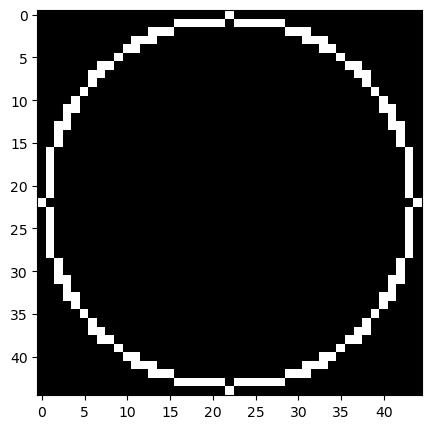

In [5]:
# Define the radius for the ring kernel
radius = int(ref_r) + 1

# Generate a ring-shaped kernel
kernel = circle.generate_ring_kernel(radius, ring_size=1)
# Create a graphics window
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(kernel, cmap='gray')
plt.show()

x= 61.72965238956686 y= 55.791091398090025


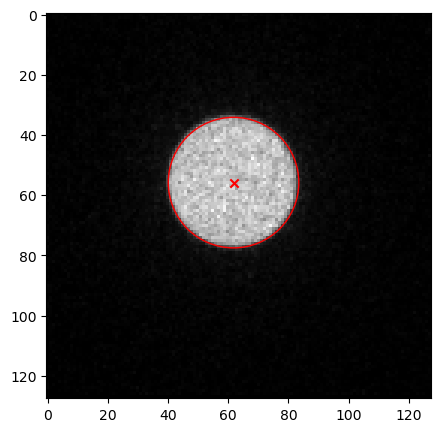

In [6]:
# Calculate the cross-correlation coordinates

#     Parameters
#     ----------
#     data1 : 2D array of int or float
#         The first 2D array.
#     data2 : 2D array of int or float
#         The second 2D array.
#     step : int, optional
#         The degree of the polynomial used for fitting. Default is 5.
#     flag : bool, optional
#         Flag indicating whether to perform filtering. Default is False.

x, y = circle.getCorre(show_one_pat, kernel,step=7) 
#x, y = circle.getCorre(show_one_pat, kernel)
print('x=', x, 'y=', y)

# Plot the result
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(show_one_pat, cmap='gray')
r = 21.7  # Radius
c = plt.Circle((x, y), r, color='red', linewidth=1, fill=False)  # Draw a circle representing the detected center
plt.scatter([x], [y], color='red', marker='x', label='True Center')  # Plot the true center
ax.add_patch(c)
plt.show()

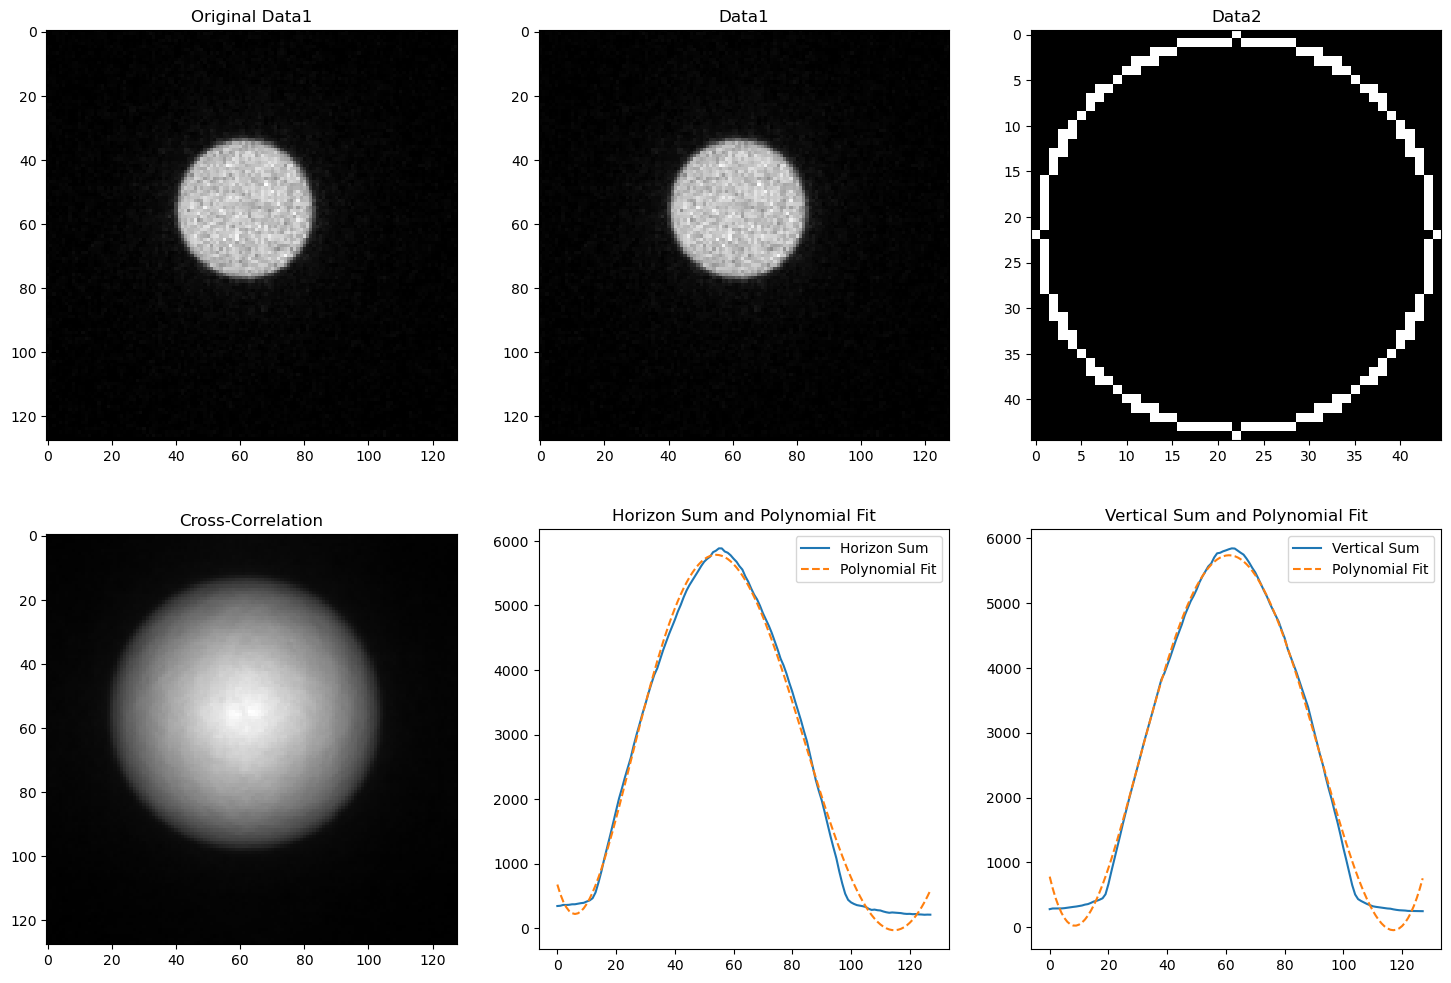

Peak coordinates: (y: 61.06921360480877, x: 54.04559049800162)


In [7]:
#Schematic drawing
y_peak, x_peak =circle.plot_Corre(show_one_pat, kernel, step=5)
print(f'Peak coordinates: (y: {y_peak}, x: {x_peak})')

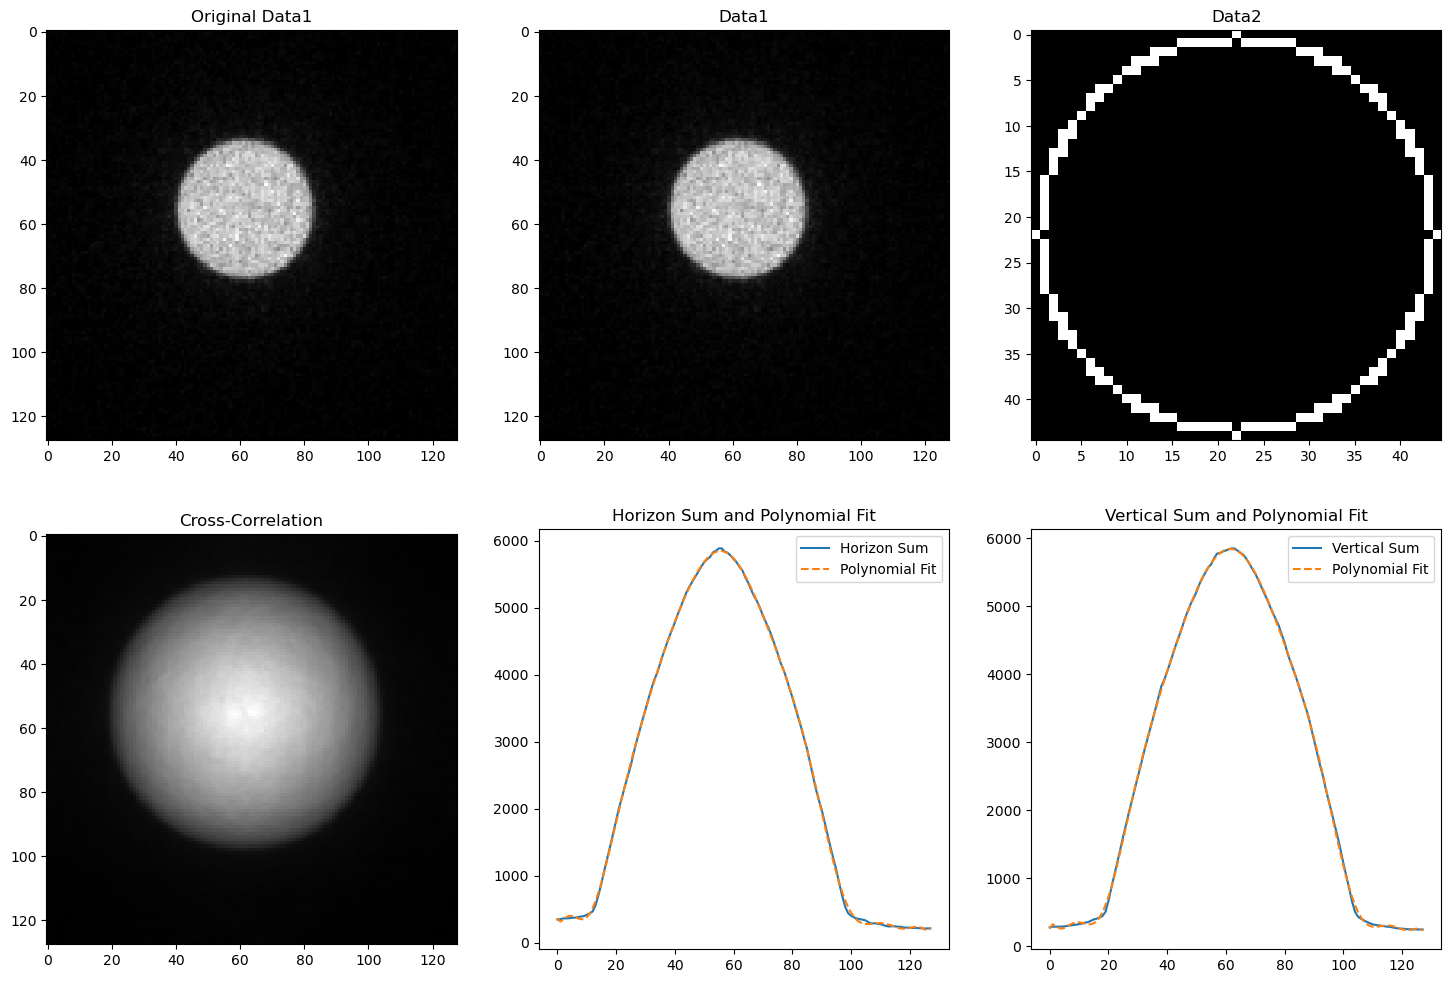

Peak coordinates: (y: 61.49794585340231, x: 55.5489788781439)


In [8]:
# Call the getCorre function and draw the image,Using high-degree polynomials 
ref = np.sum(data, axis=(0, 1)) / (imgh * imgw)
y_peak, x_peak =circle.plot_Corre(show_one_pat, kernel, step=17)
print(f'Peak coordinates: (y: {y_peak}, x: {x_peak})')

In [9]:
# Define a function to process a single data block  
def process_block(data_block):  
    """  
    Processes a single data block by applying Hough Circle Transform to detect circles  
    and collects the center coordinates of all detected circles.  
  
    Parameters:  
    data_block (numpy.ndarray): The data block to be processed, assumed to be a 2D array.  
  
    Returns:  
    result (list): A list containing the center coordinates of all detected circles,   
                   each coordinate is a (x, y) tuple.  
  
    Exception Handling:  
    If any exception occurs during processing, it prints the exception information   
    and returns an empty list.  
    """  
    try:  
        result = []  
        # Use tqdm to show progress bar, iterate over each row and column of the data block  
        for i in tqdm(range(data_block.shape[0])):  
            for j in range(data_block.shape[1]):  
                # Extract data at the current position  
                data_one_pat = data_block[i][j]  
                # Apply cross-correlation
                x_, y_ = circle.getCorre(data_one_pat, kernel, step=7)
                # Collect the center coordinates of the circle  
                result.append((x_, y_))  
        return result  
    except Exception:  
        # Print exception information and the indices where the error occurred  
        print("An exception occurs.", i, j)  
        traceback.print_exc()  
        # Return an empty list to indicate processing failure  
        return []  
  
# Define a function to process the entire dataset  
def process_data(data, num_blocks):  
    """  
    Splits the dataset into multiple blocks, processes each block in parallel,   
    and merges the results.  
  
    Parameters:  
    data (numpy.ndarray): The dataset to be processed.  
    num_blocks (int): The number of blocks to split the dataset into.  
  
    Returns:  
    merged_results (numpy.ndarray): The merged results containing the center coordinates   
                                    of all detected circles.  
  
    Note:  
    Uses joblib's Parallel and delayed functions to process data blocks in parallel. 
    
    """  
    # Split dataset 'data' into 'num_blocks' along the first axis (rows)  
    data_blocks = np.array_split(data, num_blocks, axis=0)  

    # Process each block in parallel using joblib's Parallel and delayed  
    results = Parallel(n_jobs=num_blocks)(delayed(process_block)(block) for block in data_blocks)  

    # Combine all processed block results into a single array (or list, depending on process_block's output)  
    merged_results = np.concatenate(results)

    return merged_results  

num_blocks = 50  
try:  
    # Assuming data is the predefined dataset  
    merged_results = process_data(data, num_blocks)  
    # Extract x and y coordinates  
    x = merged_results[:, 0]  
    y = merged_results[:, 1]  
except MemoryError:  
    # If insufficient memory, print message and exit  
    print("Insufficient memory, main process terminated.")  
    sys.exit(1)  
except Exception as e:  
    # Catch other exceptions and print information  
    print("An exception occurred in the main process.")  
    traceback.print_exc()  
    sys.exit(1)  

In [10]:
# data storage
file_name = r'F:\数据\互相关.csv'
data = pd.DataFrame({'x': x, 'y': y})
data.to_csv(file_name, index=False) #save data


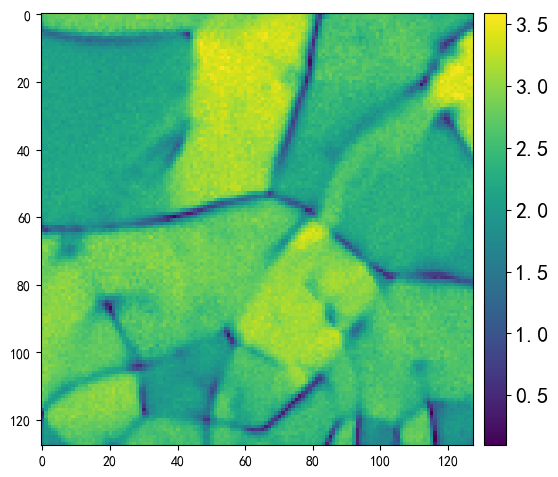

In [11]:
x,y = circle.readCsv(file_name)  # Data reading
i=int(np.sqrt(len(x)))
x=np.array(x)
y=np.array(y)

# Matrix changes to obtain the same direction as the tif image in the collection data folder
x=circle.zy_zh(x.reshape(i,i)).reshape(-1)
y=circle.zy_zh(y.reshape(i,i)).reshape(-1)

# Assuming circle.handle_X_Y is a function to process x, y coordinates  
z, x, y = circle.handle_X_Y(x, y)  
  
# Set matplotlib's font to support Chinese  
mpl.rcParams["font.sans-serif"] = ["SimHei"]  
# Create figure and axes  
fig, axs = plt.subplots(figsize=(6, 6))  
# Reshape and possibly crop z  
z = z.reshape(i, i)  
# Assuming circle.cut is a function to cut or modify the matrix z  
#z = circle.cut(z)  
# Display the image  
im = axs.imshow(z, cmap='viridis')  
# Assuming circle.add_colorbar is a function to add a colorbar  
circle.add_colorbar(im, a=16)  
plt.show()    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


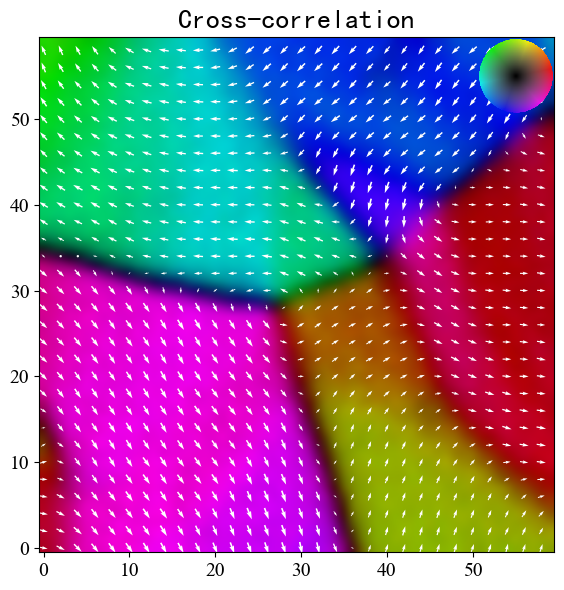

<Figure size 2400x2400 with 0 Axes>

In [12]:
a = 25
b = 85
c = 40
d = 100
scan_rotation = 0.23142782688704822  # Rotation angle obtained from the <scan_rotation></scan_rotation> tags in the XML file of the dataset

angles = -30  # Need to adjust accordingly
# x,y = circle.readCsv(file_name)
# z, x, y = circle.handle_X_Y(x, y)  

# Crop the data to the specified region
x, y = circle.cut_data(x, y, a, b, c, d)

# Set Chinese font for display
mpl.rcParams["font.sans-serif"] = ["SimHei"]

# Create subplots for plotting
fig, axs = plt.subplots(figsize=(6, 6))

# Draw the colored detail image
image = circle.drawing(axs, x, y, scan_rotation, angles=angles, step=2)
axs.set_title("Cross-correlation", fontsize=20, fontweight='bold')
axs.axis('square')

# Plot the data
circle.plot()
#plt.show()